In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [ ]:
!jupyter nbconvert --to html lab4

[NbConvertApp] Converting notebook lab4 to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 2083870 bytes to lab.html


Кумирова Екатерина M34021

**Лабораторная работа №4**

Контур Чебурашки

In [ ]:
import math as mh
import random
import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.patches as patches
import plotly.express as px

from IPython.display import Image, display
from ipywidgets import IntProgress

In [ ]:
mpl.style.use(['ggplot'])

#### **Реализация работы демона Максвелла**

In [ ]:
import numpy as np
import matplotlib.patches as patches
import math as mh
from ipywidgets import IntProgress
from IPython.display import display
from typing import Tuple

class Cheburashka:
    def __init__(self) -> None:
        # Параметры эллипсов: (центр_x, центр_y, полуось_a, полуось_b, угол_в_градусах)
        # Формат: (центр_x, центр_y, полуось_a, полуось_b, угол_в_градусах)
        self._ellipses: list[Tuple[float, float, float, float, float]] = [
            (350, 600, 150, 150, 0),    # Левое ухо
            (850, 600, 150, 150, 0),    # Правое ухо
            (600, 600, 200, 180, 0),    # Голова
            (600, 300, 160, 200, 0),    # Туловище
            (425, 325, 100, 70, 45),    # Левая рука
            (775, 325, 100, 70, -45),   # Правая рука
            (500, 100, 80, 60, 0),      # Левая нога
            (700, 100, 80, 60, 0),      # Правая нога
        ]

    def _is_inside_cheburashka(self, x: float, y: float) -> bool:
        for ellipse in self._ellipses:
            x_center, y_center, a, b, angle = ellipse
            # Перевод угла в радианы
            angle_rad = np.radians(angle)

            # Преобразование координат для учета поворота эллипса
            x_rot = (x - x_center) * np.cos(angle_rad) + (y - y_center) * np.sin(angle_rad)
            y_rot = -(x - x_center) * np.sin(angle_rad) + (y - y_center) * np.cos(angle_rad)

            if (x_rot**2 / a**2 + y_rot**2 / b**2) <= 1:
                return True
        return False


class Model:
    def __init__(self, points: int, iterations: int, cheburashka: Cheburashka) -> None:
        self._mu: float = 0.5
        self._sigma: float = 0.2

        self._x_points: np.ndarray = np.empty((self._iterations, self._points), dtype='float')
        self._y_points: np.ndarray = np.empty((self._iterations, self._points), dtype='float')
        self._points_size: np.ndarray = np.zeros(self._points)

        self._a1: float = 0.5
        self._a2: float = 0.8
        self._point_step: float = 10.5
        self._points: int = points
        self._iterations: int = iterations
        self._x_0: float = 600
        self._y_0: float = 425
        self._l_x: float = self._x_0 * 2
        self._l_y: float = self._y_0 * 2

        self._cheburashka: Cheburashka = cheburashka

        self._randomize_points()

    def _randomize_points(self) -> None:
        # нормальное распределение для определения размера частицы
        self._x_points[0] = np.random.uniform(low=0, high=self._l_x, size=self._points)
        self._y_points[0] = np.random.uniform(low=0, high=self._l_y, size=self._points)
        self._points_size = np.random.normal(self._mu, self._sigma, size=self._points)

    def _is_outside_rectangle(self, x: float, y: float) -> bool:
        return x < 0 or x > self._l_x or y < 0 or y > self._l_y

    def _get_next_step_value(self, x: float, y: float) -> Tuple[float, float]:
        point_angle = 2 * mh.pi * np.random.rand()
        x_new = x + self._point_step * np.cos(point_angle)
        y_new = y + self._point_step * np.sin(point_angle)
        return x_new, y_new

    def _maxwell(self, x: float, y: float, size: float) -> Tuple[float, float]:
        while True:
            x_new, y_new = self._get_next_step_value(x, y)
            if self._is_outside_rectangle(x_new, y_new):
                continue
            before = self._cheburashka._is_inside_cheburashka(x, y)
            after = self._cheburashka._is_inside_cheburashka(x_new, y_new)

            if size >= self._a1 and size < self._a2:
                if before and not after:
                    continue
            elif size >= self._a2:
                if before != after:
                    continue
            return x_new, y_new

    def run(self) -> None:
        vdo_step = np.vectorize(self._maxwell)
        for iter in range(1, self._iterations):
            self._x_points[iter], self._y_points[iter] = vdo_step(self._x_points[iter-1], self._y_points[iter-1], self._points_size)

    def plot_borders(self, ax) -> any:
        for ellipse in self._cheburashka._ellipses:
            x, y, a, b, angle = ellipse
            ax.add_patch(patches.Ellipse((x, y), 2*a, 2*b, angle=angle, linewidth=2, edgecolor='#7a5f7c', facecolor='none'))
        ax.add_patch(patches.Rectangle((0, 0), self._l_x, self._l_y, linewidth=2, edgecolor='#cea0af', facecolor='none', linestyle='--'))
        return ax

    def plot_points(self, iter_num: int, ax) -> any:
        colors: np.ndarray = np.empty(self._points, dtype='<U10')
        colors[self._points_size < self._a1] = '#aa83a6'
        colors[((self._points_size >= self._a1) & (self._points_size < self._a2))] = '#c05d6d'
        colors[self._points_size >= self._a2] = '#dda9b2'
        sizes: np.ndarray = np.empty(self._points, dtype='int')
        sizes[self._points_size < self._a1] = 6
        sizes[((self._points_size >= self._a1) & (self._points_size < self._a2))] = 11
        sizes[self._points_size >= self._a2] = 20
        ax.scatter(self._x_points[iter_num], self._y_points[iter_num], c=colors, s=sizes)
        return ax

    def plot_grid(self, ax) -> any:
        ax.grid(True, which='both', linewidth=0.5)
        ax.minorticks_on()
        return ax

#### **Визуализация двухмерной области экосистемы**

В качестве окружающего экосистему контура выберем прямоугольник. Создадим область фильтра, совпадающего по форме с Чебурашкой и построим изображение области фильтра.

<Axes: >

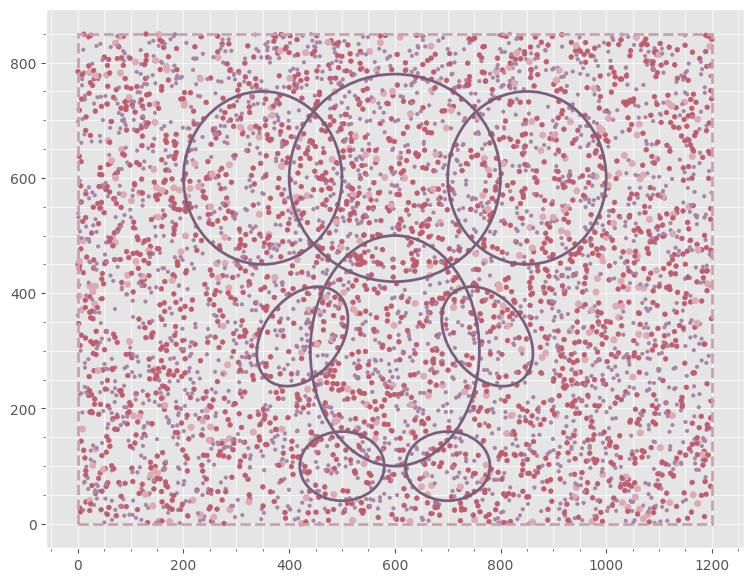

In [ ]:
cheb = Cheburashka()
model = Model(5000, 1500, cheburashka=cheb)
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots(1,1)
model.plot_points(0, ax)
model.plot_borders(ax)
model.plot_grid(ax)

In [ ]:
model.run()

#### Результат работы демона Максвелла на границе внутренней области по принципу "мембраны"

<Axes: >

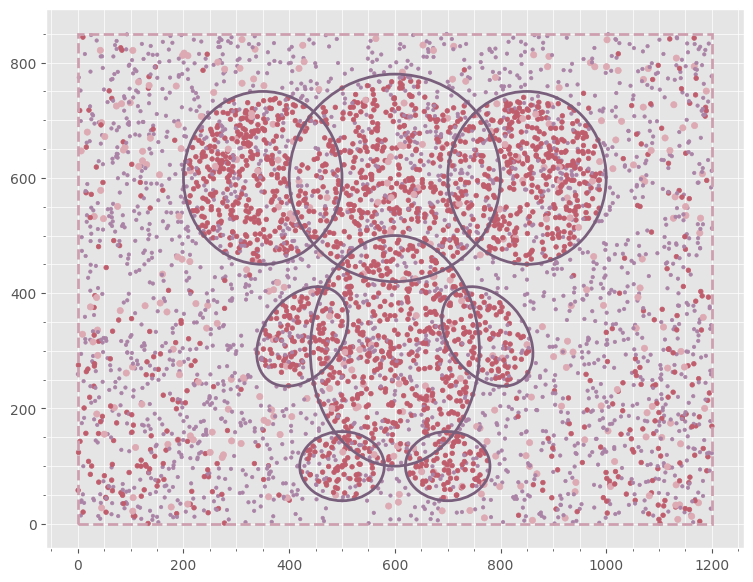

In [ ]:
fig = plt.figure(figsize=(9, 7))
ax = fig.subplots(1,1)
model.plot_points(model.iters - 1, ax)
model.plot_borders(ax)
model.plot_grid(ax)

#### **Визуализация траекторий частиц**

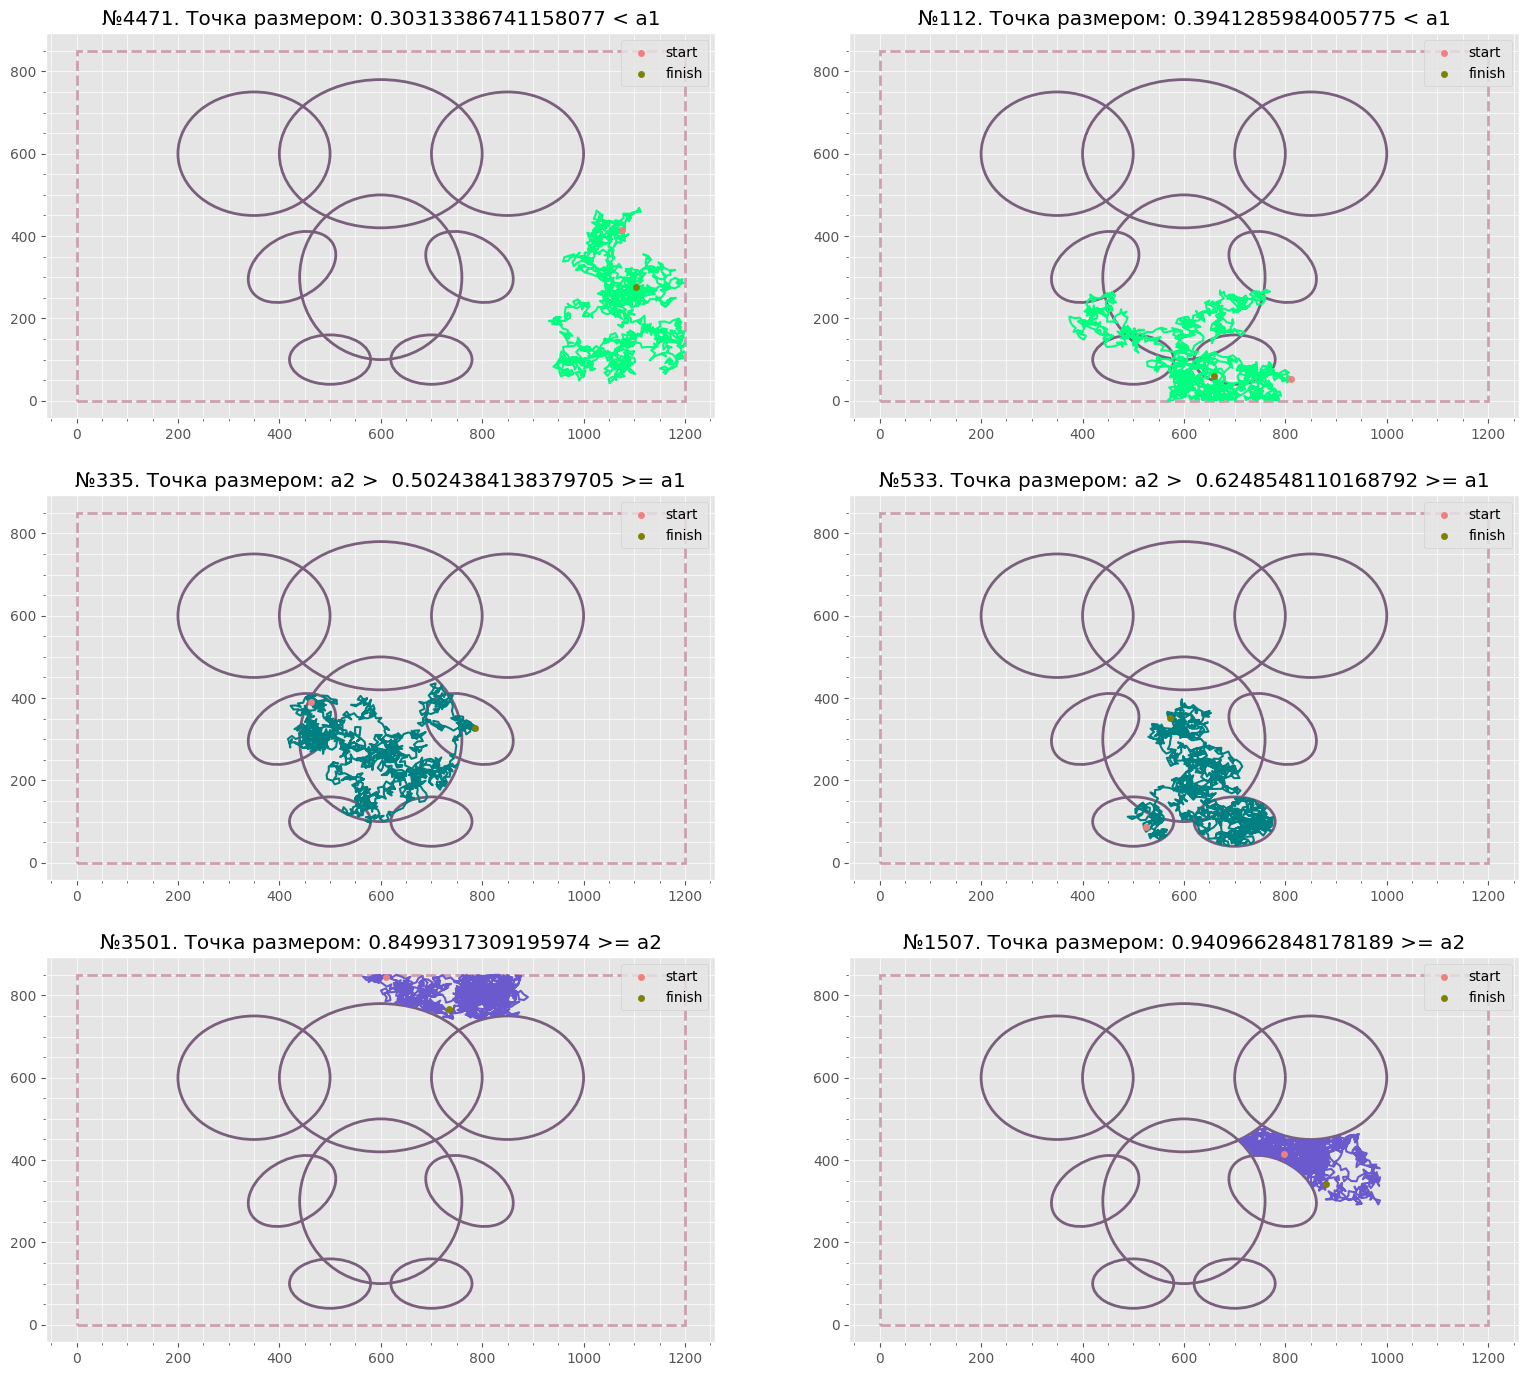

In [ ]:
small_points = [x for x in range(model.points) if model.points_size[x] < model.a1]
middle_points = [x for x in range(model.points) if model.points_size[x] >= model.a1 and  model.points_size[x] < model.a2]
big_points = [x for x in range(model.points) if model.points_size[x] >= model.a2]

fig = plt.figure(figsize=(19, 17))
h_len, v_len  = 3, 2
ax = fig.subplots(h_len, v_len)
small_numbers = [small_points[int(x)] for x in len(small_points) * np.random.rand(h_len)]
middle_numbers = [middle_points[int(x)] for x in len(middle_points) * np.random.rand(h_len)]
big_numbers = [big_points[int(x)] for x in len(big_points) * np.random.rand(h_len)]

def draw_trajectory(ax, x, y, color):
  ax.scatter(x[0], y[0], color='lightcoral', s=20, zorder=3, label="start")
  ax.scatter(x[-1], y[-1], color='olive', s=20, zorder=3, label="finish")
  ax.plot(x, y, color=color)
  ax.legend()

for i in range(0, v_len):
    draw_trajectory(ax[0][i], model.x_points[:, small_numbers[i]], model.y_points[:,small_numbers[i]], 'springgreen')
    ax[0][i].set_title(f"№{small_numbers[i]}. Точка размером: {model.points_size[small_numbers[i]]} < a1")
    model.plot_borders(ax[0][i])
    model.plot_grid(ax[0][i])

    draw_trajectory(ax[1][i], model.x_points[:, middle_numbers[i]], model.y_points[:, middle_numbers[i]], 'teal')
    ax[1][i].set_title(f"№{middle_numbers[i]}. Точка размером: a2 >  {model.points_size[middle_numbers[i]]} >= a1")
    model.plot_borders(ax[1][i])
    model.plot_grid(ax[1][i])

    draw_trajectory(ax[2][i], model.x_points[:, big_numbers[i]], model.y_points[:, big_numbers[i]], 'slateblue')
    ax[2][i].set_title(f"№{big_numbers[i]}. Точка размером: {model.points_size[big_numbers[i]]} >= a2")
    model.plot_borders(ax[2][i])
    model.plot_grid(ax[2][i])


#### **Расчет площади внутренней фигуры с численными параметрами**

In [ ]:
def calculate_cheburashka_area(cheburashka):
    total_area = 0
    for ellipse in cheburashka.ellipses:
        x, y, a, b, angle = ellipse
        ellipse_area = mh.pi * a * b
        total_area += ellipse_area
    return total_area

In [ ]:
def calculate_cheburashka_area(cheburashka, num_points=50000):
    points_inside = 0
    for _ in range(num_points):
        x = np.random.uniform(0, model.l_x)
        y = np.random.uniform(0, model.l_y)

        if cheburashka.is_inside_cheburashka(x, y):
            points_inside += 1

    rectangle_area = model.l_x * model.l_y
    cheburashka_area = (points_inside / num_points) * rectangle_area
    return cheburashka_area
cheb = Cheburashka()

estimated_area = calculate_cheburashka_area(cheb)

In [ ]:
experinents_count = 1000
squares = np.empty(experinents_count, dtype='float')

for i in range(experinents_count):
    new_model = Model(15000, 1, cheburashka=cheb)
    new_model.a2 = 0.7

    inside, all = count_points(new_model, new_model.x_points[0, :], new_model.y_points[0, :])
    coef = inside / all

    rectangle_square = model.l_x * model.l_y
    cheburashka_square = rectangle_square * coef
    squares[i] = cheburashka_square

#### **Оценка статистических параметров получившегося распределения площади**

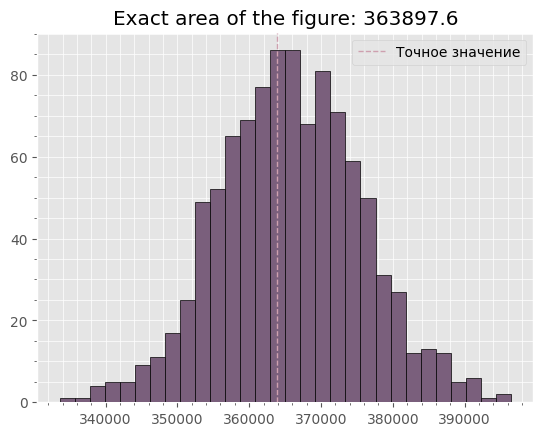

In [ ]:
plt.grid(True, which='both', linewidth=0.5, zorder=-1000)
plt.minorticks_on()
plt.hist(squares, 30, color='#7a5f7c', edgecolor='k', zorder = 5)
plt.axvline(estimated_area, color='#cea0af', linestyle='dashed', linewidth=1, label="Точное значение", zorder=10)
plt.title(f"Exact area of ​​the figure: {estimated_area}")
plt.legend()
plt.show()

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ["Статистический параметр", "Значение"]
table.title = "Статистические параметры распределения площади"

table.add_row(["Матожидание", f"{np.mean(squares):.2f}"])
table.add_row(["Дисперсия", f"{np.var(squares):.2f}"])
table.add_row(["Среднеквадратичное отклонение", f"{np.std(squares):.2f}"])

print(table)

+------------------------------------------------+
| Статистические параметры распределения площади |
+---------------------------------+--------------+
|     Статистический параметр     |   Значение   |
+---------------------------------+--------------+
|           Матожидание           |  365743.08   |
|            Дисперсия            | 97200814.81  |
|  Среднеквадратичное отклонение  |   9859.05    |
+---------------------------------+--------------+


#### **Расчет эффективности фильтра**

In [ ]:
def count_inside(model, x, y):
  inside = 0
  all = 0
  for i in range(len(x)):
    if model.points_size[i] >= model.a1 and model.points_size[i]< model.a2:
      all +=1
      if model.cheburashka.is_inside_cheburashka(x[i],y[i]):
        inside += 1
  return inside, all

Ширина коридора меняется из-за увеличивающегося на каждой итерации a2:

In [ ]:
delta = 0.05
mean = 0.5
a1 = 0.4
a2 = a1 + delta
iters = 30
step_size = 25

starts2 = np.empty(iters, dtype='int')
ends2 = np.empty(iters, dtype='int')
all2 = np.empty(iters, dtype='int')

for i in range(iters):
  new_model = Model(10000, 500, cheburashka=cheburashka)
  new_model.point_step = step_size
  new_model.a1 = a1
  new_model.a2 = a2
  starts2[i], all2[i]=(count_inside(new_model, new_model.x_points[0,:], new_model.y_points[0,:]))
  new_model.run()
  ends2[i], _=(count_inside(new_model, new_model.x_points[new_model.iters-1,:], new_model.y_points[new_model.iters-1,:]))
  a2 += delta

#### **График регрессионной зависимости эффективности фильтра от ширины коридора**

Text(0.5, 0, 'Ширина коридора между a1 и a2')

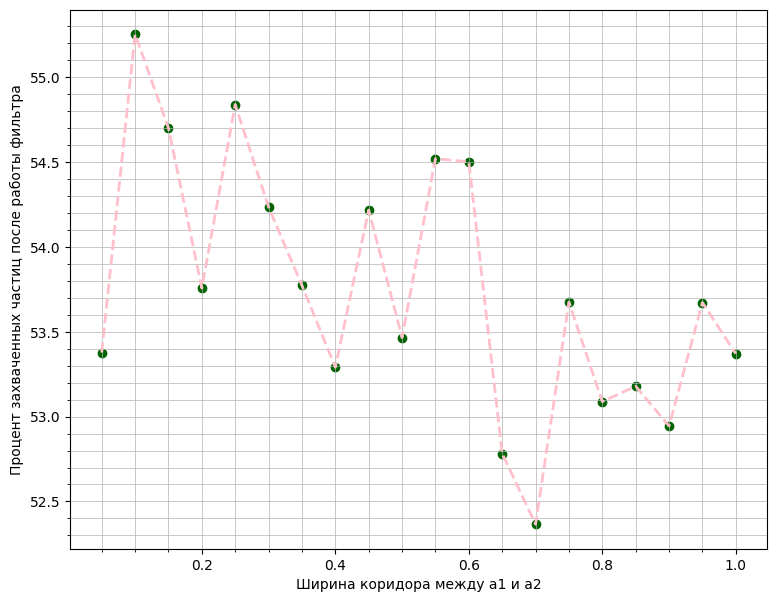

In [ ]:
diff2 = ends2 - starts2
deltas2 = [x*delta for x in range(1, 21)]
percent = ((diff2/all2) * 100)[0:20]
fig = plt.figure(figsize=(9, 7))
ax = fig.subplots(1,1)
ax.grid(True, which='both', linewidth=0.5)

ax.plot( deltas2, percent, color="pink", linestyle='dashed', linewidth=2)
ax.scatter( deltas2, percent, color="darkgreen")
ax.minorticks_on()
ax.set_ylabel("Процент захваченных частиц после работы фильтра")
ax.set_xlabel("Ширина коридора между a1 и a2")

Видим, что в среднем коэффициент практически не изменяется при изменении ширины
коридора.